https://fred.stlouisfed.org/categories/27281

https://fred.stlouisfed.org/series/MSPUS

site:https://fred.stlouisfed.org dallas property price

In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf
import numpy as np

pysqldf = lambda q: sqldf(q, globals())

In [2]:
property_price_csv = 'history/MSPUS_usa.csv'
nasdaq_data_csv = 'history/NDX.csv'
#nasdaq_data_csv = 'history/GSPC.csv'

In [3]:
year_duration = 30
window_size = year_duration*4

In [4]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2})\, (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date

date = 'Jun 14 2022'
date = '1/1/1976'
date = 'Jul 01, 2022'

date_normalize(
    date,
    )

'2022-07-01'

In [5]:
property_data = pd.read_csv(
    property_price_csv,
    )

property_data.rename(columns = {property_data.columns[0]:'day', property_data.columns[1]:'price'}, inplace = True)

property_data['Date'] = property_data[property_data.columns[0]].apply(date_normalize)
property_data['Month'] = property_data['Date'].apply(lambda x:x.split('-')[0]+'-'+x.split('-')[1])

property_data['Close'] = property_data[property_data.columns[1]].apply(lambda x: float(x))
property_data['id'] = property_data.index

property_data.tail(3)

,day,price,Date,Month,Close,id
235,2021-10-01,423600.0,2021-10-01,2021-10,423600.0,235
236,2022-01-01,433100.0,2022-01-01,2022-01,433100.0,236
237,2022-04-01,440300.0,2022-04-01,2022-04,440300.0,237


In [6]:
nasdaq_data = pd.read_csv(
    nasdaq_data_csv,
    )

nasdaq_data['Date'] = nasdaq_data['Date'].apply(date_normalize)
nasdaq_data['Month'] = nasdaq_data['Date'].apply(lambda x:x.split('-')[0]+'-'+x.split('-')[1])

nasdaq_data['Close'] = nasdaq_data['Close'].apply(lambda x: float(re.sub(r'[^\d\.]+', '', x)))
nasdaq_data['id'] = nasdaq_data.index

In [7]:
nasdaq_data.head(3)

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close**,Volume,Month,id
0,0,2022-07-01,"3,781.00","3,829.82","3,752.10",3825.33,"3,825.33","3,268,240,000",2022-07,0
1,1,2022-06-30,"3,785.99","3,818.99","3,738.67",3785.38,"3,785.38","4,032,260,000",2022-06,1
2,2,2022-06-29,"3,825.09","3,836.50","3,799.02",3818.83,"3,818.83","3,458,850,000",2022-06,2


In [8]:
nasdaq_data_month = pysqldf(u"""
    select Month, avg(Close) as Close
    from nasdaq_data
    group by Month
    """)

nasdaq_data_month.head(3)

,Month,Close
0,1927-12,17.660000
1,1928-01,17.520000
2,1928-02,17.324211


In [9]:
compare_date = pysqldf(u"""
    select 
    p.Date,
    p.Month, 
    p.Close as Property_Price,
    n.Close as NQ100_Price
    from property_data as p
    join nasdaq_data_month as n on n.Month = p.Month
    where p.Date >= '1985-10-10'
    order by p.Month asc
    """)

compare_date['id'] = compare_date.index

compare_date.head(3)

,Date,Month,Property_Price,NQ100_Price,id
0,1986-01-01,1986-01,88000.0,208.194091,0
1,1986-04-01,1986-04,92100.0,237.967727,1
2,1986-07-01,1986-07,93000.0,240.180000,2


<AxesSubplot:xlabel='Date'>

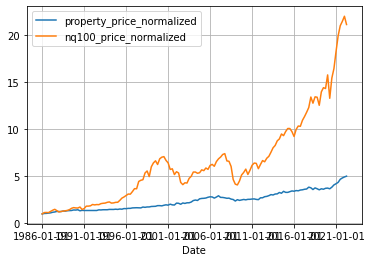

In [10]:
compare_date['property_price_normalized'] = compare_date['Property_Price']/compare_date['Property_Price'][0]
compare_date['nq100_price_normalized'] = compare_date['NQ100_Price']/compare_date['NQ100_Price'][0]

compare_date.plot(
    x ='Date', y=[
    'property_price_normalized',
    'nq100_price_normalized', 
    ], grid = True)

<AxesSubplot:xlabel='Date'>

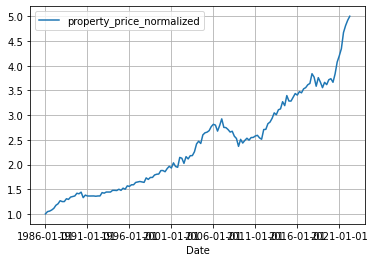

In [11]:
compare_date.plot(
    x ='Date', y=[
    'property_price_normalized',
    ], grid = True)

<AxesSubplot:xlabel='Date'>

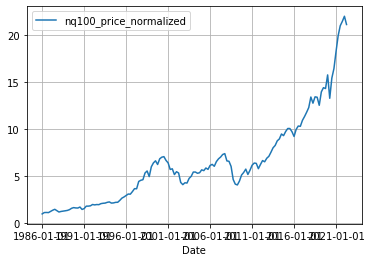

In [12]:
compare_date.plot(
    x ='Date', y=[
    'nq100_price_normalized',
    ], grid = True)

In [13]:
compare_date_now_old = pysqldf(u"""
    select 
    now.*,
    old.Date as Date_old,
    old.Property_Price as Property_Price_old,
    old.NQ100_Price as NQ100_Price_old    
    from compare_date as now
    join compare_date as old
    on old.id + {} = now.id
    """.format(window_size))

In [14]:
compare_date_now_old.tail(3)

,Date,Month,Property_Price,NQ100_Price,id,property_price_normalized,nq100_price_normalized,Date_old,Property_Price_old,NQ100_Price_old
23,2021-10-01,2021-10,423600.0,4460.707143,143,4.813636,21.425714,1991-10-01,120000.0,386.883478
24,2022-01-01,2022-01,433100.0,4573.815500,144,4.921591,21.968998,1992-01-01,119500.0,416.075000
25,2022-04-01,2022-04,440300.0,4391.296000,145,5.003409,21.092318,1992-04-01,120000.0,407.407143


In [15]:
Stock2Property = pysqldf(u"""
    select *,
    Property_Price/Property_Price_old as Property_Rate,
    ((Property_Price/Property_Price_old)*5 - 4*(1-{}/30)) as Leveraged_Property_Ratio,
    NQ100_Price/NQ100_Price_old as NQ100_Rate
    from compare_date_now_old
    """.format(year_duration))

Stock2Property = pysqldf(u"""
    select *,
    NQ100_Rate/Property_Rate as Stock2Property,
    NQ100_Rate/Leveraged_Property_Ratio as Stock2Leveraged_Property    
    from Stock2Property
    """)

In [16]:
Stock2Property.tail(3)

,Date,Month,Property_Price,NQ100_Price,id,property_price_normalized,nq100_price_normalized,Date_old,Property_Price_old,NQ100_Price_old,Property_Rate,Leveraged_Property_Ratio,NQ100_Rate,Stock2Property,Stock2Leveraged_Property
23,2021-10-01,2021-10,423600.0,4460.707143,143,4.813636,21.425714,1991-10-01,120000.0,386.883478,3.530000,17.650000,11.529847,3.266245,0.653249
24,2022-01-01,2022-01,433100.0,4573.815500,144,4.921591,21.968998,1992-01-01,119500.0,416.075000,3.624268,18.121339,10.992767,3.033100,0.606620
25,2022-04-01,2022-04,440300.0,4391.296000,145,5.003409,21.092318,1992-04-01,120000.0,407.407143,3.669167,18.345833,10.778643,2.937627,0.587525


<AxesSubplot:xlabel='Date'>

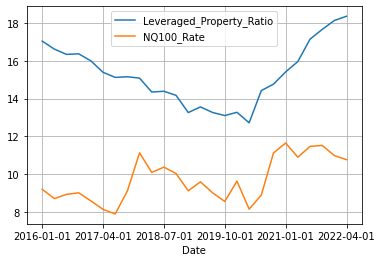

In [17]:
Stock2Property.plot(
    x ='Date', 
    y=[
    'Leveraged_Property_Ratio', 
    'NQ100_Rate', 
    ], grid = True)

np.std(Stock2Property['Leveraged_Property_Ratio'])

np.std(Stock2Property['NQ100_Rate'])

<AxesSubplot:>

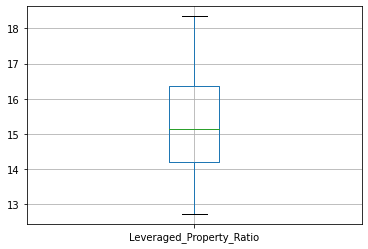

In [18]:
Stock2Property.boxplot(column=['Leveraged_Property_Ratio']) 

<AxesSubplot:>

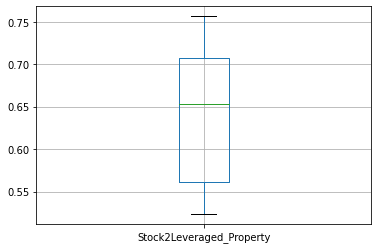

In [19]:
Stock2Property.boxplot(column=['Stock2Leveraged_Property']) 

In [20]:
nq100_to_leveraged_property_ratio = Stock2Property['Stock2Leveraged_Property'].median()

print('Nasdaq to Leveraged Property Ratio:\t%0.4f'%(nq100_to_leveraged_property_ratio))

Nasdaq to Leveraged Property Ratio:	0.6537


In [21]:
nq100_ratio = Stock2Property['NQ100_Rate'].median()

nq100_ratio_min = Stock2Property['NQ100_Rate'].min()

print('Nasdaq Ratio:\t%0.4f, min:\t%0.4f'%(nq100_ratio, nq100_ratio_min))

Nasdaq Ratio:	9.4113, min:	7.9142


In [22]:
leveraged_property_ratio = Stock2Property['Leveraged_Property_Ratio'].median()

leveraged_property_ratio_min = Stock2Property['Leveraged_Property_Ratio'].min()

print('Leveraged Property Ratio:\t%0.4f, min:\t%0.4f'%(leveraged_property_ratio, leveraged_property_ratio_min))

Leveraged Property Ratio:	15.1352, min:	12.7208


#### END